In [129]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
# TO USE:
# Uncomment three !pip install lines
# Run this cell ONLY
# Runtime -> Restart session
# Comment three !pip install lines
# Run all

# Andy can push

# Pandas 1.5.3
# Numpy 1.26.3
# Json 2.0.9
# NLTK (Natural Language Toolkit) 3.8.1
# Gensim 4.3.2
# Spacy 3.6.1
# PyLDAvis 3.4.0
# re (removing characters) 2.2.1
# clean from cleantext
# from prompt_toolkit.completion import word_completer
# from pprint import pprint
# import matplotlib.pyplot as plt


%pip install pyLDAvis
%pip install --user -U nltk
%pip install -U spacy
%pip install "pandas==1.5.3"


  Using cached pandas-2.2.1-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.1-cp311-cp311-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3

Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-1.5.3-cp311-cp311-win_amd64.whl.metadata (12 kB)
Using cached pandas-1.5.3-cp311-cp311-win_amd64.whl (10.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [130]:
#

import numpy as np
import json
import glob
import nltk
import pandas as pd #to work with csv files

# pd.__version__ = 2.0.0
print(pd.__version__)

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

1.5.3


In [131]:
import os
#The function that loops through the data to check for optimal parameters to input into the LDA model would take over 16 hours to run,
#after a while the runtime disconnects, which makes the progress start from 0.
#so the purpose of this function is to make sure the runtime doesnt disconnect, while training for optimal params to input to lda model.

#def check_and_reconnect_drive():
    #try:
        # Check if Google Drive is still connected
     #   os.listdir('/content/drive')
  #  except:
        # If not, reconnect it
  #      from google.colab import drive
  #      drive.mount('/content/drive', force_remount=True)

# Then call this function every so often in your main script
#check_and_reconnect_drive()

In [132]:
nltk.download('stopwords')

stopwords = stopwords.words("english") #get stopwords from nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
#stopwords.extend(['hi', 'anymore', 'years', 'ago', 'almost', 'somehow', 'remember', 'wants', 'either', 'enough', 'much', 'making', 'simple', 'things', 'add', 'actual', 'say', 'etc', 'anything', 'days', 'long', 'another', 'ever', 'yes', 'th', 'ice', 'mightymouse', 'should', 'obviously', 'even', 'lol', 'stuff', 'never', 'old', 'yr', 'bit', 'like', 'aka', 'nonsense', 'ok', 'absolutely', 'op', 'weird', 'ass', 'fully', 'get', 'would', 'definitely', 'especially', 'still', 'else', 'something', 'often', 'kind', 'let', 'lot', 'able', 'non', 'pg', 'nice', 'trad', 'keep', 'massive', 'quickly', 'be', 'common', 'tv', 'fuckin', 'im', 'could', 'also', 'silly', 'ie', 'seem', 'seems', 'fucked'])#Add custom stop words
stopwords.extend(['r/parenting', 'r/roblox', 'get'])#Add reddit paths

In [134]:
def wordcounts(text1):
  fdist1 = FreqDist(text1)
  print(fdist1)
  fdist1.most_common(50)

In [135]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [136]:
def load_data(file):
  data = pd.read_csv(file)
  return data

In [137]:
data = load_data('../Used_Dataset/finalCumulative.csv')
filtered_data = data.drop(columns=['subreddit','date','timestamp'], axis=1)
data = filtered_data.replace('\n', ' ', regex=True)
# data.head(5)

In [138]:
# data[data.text.str.contains('I am a bot')]

In [139]:
import re

data = data.loc[data.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
data['text'] = data['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

data['text'] = data['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\(', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\)', ' ', x))
data['text'] = data['text'].replace(r'&\S+', '', regex=True)
data['text'] = data['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
data['text'] = data['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
data['text'] = data['text'].map(lambda x: re.sub(pattern, ' ', x))
data['text'] = data['text'].map(lambda x: re.sub(' +', ' ', x))

data.shape

(22911, 2)

In [140]:
data.columns

Index(['Unnamed: 0', 'text'], dtype='object')

In [141]:
data.head(5)

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [142]:
data[data.text.str.contains('I am a bot')]

,Unnamed: 0,text


In [143]:
data['text'][51]

"hey i'm not a parent but i have a little brother and i'm consered for him because in most games he plays there's the blox ____ scams i won't actually say the links because people could accidentally click it but i have to remind him every time he plays mom won't let him spend money on there cuz he's too young so he's trying to get free robux "

In [144]:
!pip install clean-text
from cleantext import clean

In [145]:
data = [clean(d, no_emoji=True) for d in data['text']]

In [146]:
data = remove_stopwords(data)

In [147]:
resultx = []
for d in data:
  resultx.append(' '.join(d))

#resultxtokens = resultx.split()


In [148]:
resultx[:5]

['concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss amon

In [149]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
words = [word_tokenize(i) for i in resultx]
words2= [num for elem in words for num in elem]
#words = nltk.tokenize.word_tokenize(resultx)

#wordcounts(words2)
fdist1 = FreqDist(words2)
#print(fdist1)
fdist1.most_common(50)


#>>> # flatten a list using a listcomp with two 'for'
#>>> vec = [[1,2,3], [4,5,6], [7,8,9]]
#>>> [num for elem in vec for num in elem]
#[1, 2, 3, 4, 5, 6, 7, 8, 9]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('game', 6524),
 ('like', 5984),
 ('games', 5246),
 ('kids', 4437),
 ('roblox', 4332),
 ('play', 3403),
 ('time', 3397),
 ('would', 2991),
 ('people', 2948),
 ('one', 2532),
 ('think', 2462),
 ('also', 2443),
 ('money', 2409),
 ('make', 2397),
 ('know', 2375),
 ('good', 2314),
 ('kid', 2313),
 ('even', 2248),
 ('old', 2155),
 ('year', 2033),
 ('really', 2012),
 ('pokemon', 1922),
 ('want', 1867),
 ('much', 1857),
 ('things', 1834),
 ('still', 1804),
 ('something', 1746),
 ('way', 1703),
 ('playing', 1580),
 ('better', 1486),
 ('could', 1458),
 ('let', 1449),
 ('child', 1422),
 ('buy', 1403),
 ('phone', 1401),
 ('see', 1379),
 ('need', 1359),
 ('got', 1343),
 ('go', 1313),
 ('never', 1286),
 ('lot', 1277),
 ('say', 1275),
 ('friends', 1266),
 ('back', 1264),
 ('going', 1260),
 ('thing', 1247),
 ('son', 1240),
 ('well', 1227),
 ('daughter', 1215),
 ('bad', 1210)]

In [150]:
result = []
for d in data:
  result.append(' '.join(d))
# result

In [151]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = filtered_data.review_text_processed.values.tolist()
data_words = list(sent_to_words(result))

# prints the first 30 words of the first tokenized review from the data_words list.
# print(data_words[:1][0][:30])

In [152]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# # NO BIGRAMS
# !python -m spacy download en_core_web_sm
# import spacy

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# BIGRAMS DATA
!python -m spacy download en_core_web_sm
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for unigram
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram
# data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 325.1 kB/s eta 0:00:40
      --------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.4/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.7/12.8 MB 3.1 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 4.0 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 4.6 MB/s eta 0:00:03
     ----- ---------------------------------- 1.9/12.8 MB 5.0 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 5.7 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 5.8 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 6.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.5/12.8 MB 6.4 MB/

In [ ]:
print(type(data_lemmatized))

<class 'list'>


Remove Duplicate Words (TO REMOVE)

In [ ]:
# from collections import Counter
# def unique(d):
#   UniqW = Counter(d)
#   result = [*UniqW]
#   # corpus = ' '.join(UniqW.keys())
#   return result

In [ ]:
# single_data = []
# for d in data_lemmatized:
#   for word in d:
#     single_data.append(word)

In [ ]:
# unique_data = [unique(d) for d in data_lemmatized]
# # unique_data = unique(single_data)

In [ ]:
# print(type(unique_data))

In [ ]:
# unique_data

In [ ]:
from prompt_toolkit.completion import word_completer
id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(bag_of_words)

corpus = []
for text in data_lemmatized:
  new = id2word.doc2bow(text)
  corpus.append(new)

print(corpus[0])

print(data_words[:1][0][:30])
# print(word_completer)

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 2), (12, 7), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 2), (31, 1), (32, 10), (33, 4), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 4), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 4), (59, 1), (60, 1), (61, 5), (62, 3), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 5), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 3), (92, 2), (93, 1), (94, 1), (95, 3), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 2), (105, 3), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.01,
                                       eta=0.61)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.129561 -0.149983       1        1  40.331111
1     -0.013028 -0.192406       2        1  29.621419
3     -0.156466  0.039575       3        1  26.426065
4      0.092997  0.198847       4        1   2.254039
0      0.206058  0.103967       5        1   1.367365, topic_info=        Term          Freq         Total Category  logprob  loglift
32      game  10155.000000  10155.000000  Default  30.0000  30.0000
887  pokemon   1600.000000   1600.000000  Default  29.0000  29.0000
40       kid   5806.000000   5806.000000  Default  28.0000  28.0000
74    roblox   2625.000000   2625.000000  Default  27.0000  27.0000
156    money   2195.000000   2195.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
790     word      8.626819    234.801971   Topic5  -6.5221   0.9884
45         m      8.093068    160.038549   Topic5  -6.5860   1.3079
236    blame      7.387458    103.534486   Topic5  -6.6772   1.6522
118  exactly      7.439503    242.532094   Topic5  -6.6702   0.8080
61    people      6.925526   2510.650260   Topic5  -6.7418  -1.6008

[388 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
468        3  0.971795      aaa
756        1  0.066192   access
756        2  0.931529   access
756        3  0.001614   access
926        1  0.001344  account
...      ...       ...      ...
4372       2  0.011399     yell
4372       3  0.011399     yell
4372       5  0.011399     yell
15146      3  0.188214    youuu
15146      5  0.564642    youuu

[1044 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"lol" + 0.006*"reddit" + 0.005*"makeup" + 0.004*"man" + '
  '0.003*"comment" + 0.003*"inner_beauty" + 0.003*"post" + 0.003*"woman" + '
  '0.003*"agree" + 0.003*"idiot"'),
 (1,
  '0.017*"kid" + 0.014*"money" + 0.013*"roblox" + 0.011*"make" + 0.011*"use" + '
  '0.010*"child" + 0.010*"phone" + 0.009*"game" + 0.008*"want" + 0.008*"know"'),
 (2,
  '0.021*"kid" + 0.019*"play" + 0.014*"time" + 0.012*"game" + 0.011*"go" + '
  '0.010*"old" + 0.009*"thing" + 0.009*"think" + 0.009*"year" + 0.009*"want"'),
 (3,
  '0.062*"game" + 0.016*"look" + 0.014*"pokemon" + 0.014*"buy" + 0.012*"play" '
  '+ 0.012*"people" + 0.011*"make" + 0.011*"well" + 0.009*"good" + '
  '0.007*"switch"'),
 (4,
  '0.012*"shoe" + 0.008*"minecraft" + 0.006*"pet" + 0.006*"brand" + '
  '0.005*"adopt" + 0.005*"roblox" + 0.005*"pair" + 0.004*"converse" + '
  '0.004*"fake" + 0.004*"simulator"')]


In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, corpus=corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5399501751923828


In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss among 

In [ ]:

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

#data_words

In [ ]:
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}

#  # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# #A list of alpha values to be tested.
# #It includes a range of values from 0.01 to 1 with a step size of 0.3, as well as two special values: 'symmetric' and 'asymmetric'.
# alpha = list(np.arange(0.01, 1, 0.3))
#  #assumes that all documents are equally likely to be a mixture of topics, resulting in a uniform distribution of topics across documents. So it maps rreviews to each topic evenly
#  #It makes the model assume that every document should have roughly the same proportion of topics.
# # alpha.append('symmetric')
# # #allows for more variability in document-topic proportions.
# # #It doesn't enforce a uniform distribution and allows documents to have varying degrees of focus on different topics.
# alpha.append('asymmetric')

# # # Beta parameter
# # #A list of beta values to be tested. It follows a similar pattern to alpha, including a range and 'symmetric'.
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # # Validation sets:
# # # We have the corpus sets, which contains 2 versions of the corpus, 15% and 20%
# num_of_docs = len(corpus)

# # #A list containing two versions of the 15% corpus, one with 20% of the documents and another with 15% of the documents.
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.20)),
#                gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.15))]

# corpus_title = ['20% Corpus', '15% Corpus']

# #Stores the results of the LDA model with different hyperparameters.
# model_results = {'Validation_Set': [],
#                   'Topics': [],
#                   'Alpha': [],
#                   'Beta': [],
#                   'Coherence': []
#                  }

#  # Can take a long time to run
# if 1 == 1:
#    #progress bar
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#      # iterate through validation corpus sets
#     for i in range(len(corpus_sets)):
#          # iterate through number of topics
#         for k in topics_range:
#              # iterate through alpha values
#             for a in alpha:
#                  # iterare through beta values
#                 for b in beta:
#                      #reconnect the runtime
#                    # check_and_reconnect_drive()
#                      # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
#                                                   k=k, a=a, b=b)

#                      # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a) 
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#      # pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Classes/lda_tuning_results.csv', index=False)
#     pbar.close()

In [ ]:
import os


print(os.getcwd())

c:\Users\Owner\Favorites\LDA_Analysis\Code


In [ ]:
# if 1==1:
# # pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#     pbar.close()

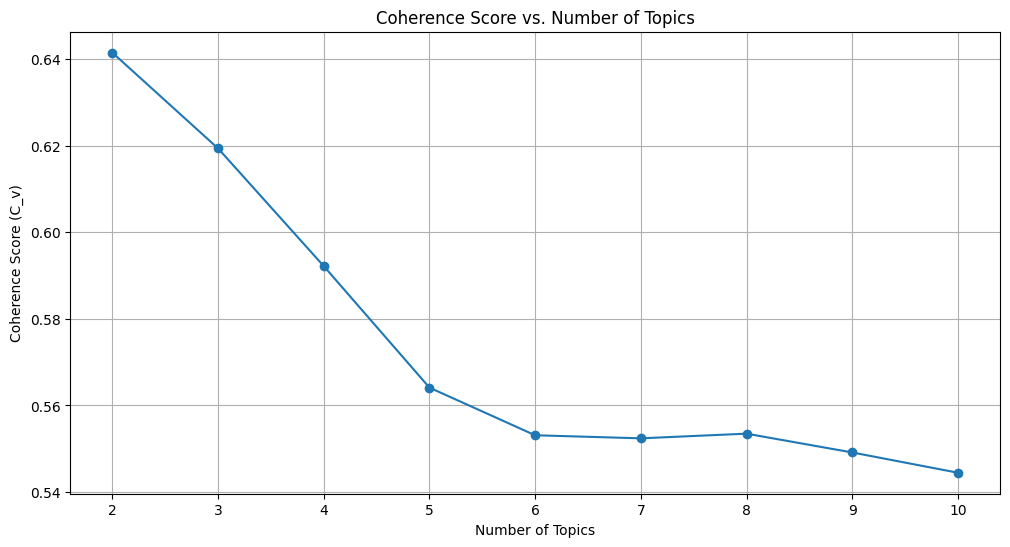

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Load the model results from the CSV file
model_results_df = pd.read_csv('../Dataset/lda_tuning_results.csv')

# Filter the results for the 75% Corpus (you can change this if needed)
# filtered_results = model_results_df[model_results_df['Validation_Set'] == '20% Corpus']

# Group the results by the number of topics (Topics) and calculate the mean coherence score
coherence_by_topics = model_results_df.groupby('Topics')['Coherence'].mean()

# Plot the coherence score against the number of topics
plt.figure(figsize=(12, 6))
plt.plot(coherence_by_topics.index, coherence_by_topics.values, marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [ ]:
data_topic_3 = model_results_df[model_results_df['Topics'] == 2]
max_coherence = np.array(data_topic_3['Coherence'])
print(max(model_results_df['Coherence']))
#print(max_coherence[4])
#print(np.argmax(max_coherence))

0.723257906711438


##Visualizing the Data


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.129561 -0.149983       1        1  40.334078
1     -0.013028 -0.192406       2        1  29.612959
3     -0.156466  0.039575       3        1  26.431195
4      0.092997  0.198847       4        1   2.256946
0      0.206058  0.103967       5        1   1.364823, topic_info=        Term          Freq         Total Category  logprob  loglift
32      game  10156.000000  10156.000000  Default  30.0000  30.0000
887  pokemon   1600.000000   1600.000000  Default  29.0000  29.0000
40       kid   5805.000000   5805.000000  Default  28.0000  28.0000
74    roblox   2625.000000   2625.000000  Default  27.0000  27.0000
156    money   2195.000000   2195.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
790     word      8.610777    234.781880   Topic5  -6.5221   0.9885
45         m      8.078019    160.036227   Topic5  -6.5860   1.3079
236    blame      7.373721    103.521616   Topic5  -6.6772   1.6523
118  exactly      7.425670    242.517656   Topic5  -6.6702   0.8080
61    people      6.912648   2510.774162   Topic5  -6.7418  -1.6008

[388 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
468        3  0.971613      aaa
756        1  0.066209   access
756        2  0.931772   access
756        3  0.001615   access
926        1  0.001345  account
...      ...       ...      ...
4372       2  0.011399     yell
4372       3  0.011399     yell
4372       5  0.011399     yell
15146      3  0.188417    youuu
15146      5  0.565250    youuu

[1043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

In [ ]:
lda_model_tuned = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.9099999999999999,
                                       eta=0.9099999999999999)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tuned, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.020544  0.297976       1        1  39.034999
5      0.189677  0.154566       2        1  19.966326
6     -0.171937  0.155333       3        1  15.524809
3      0.098179 -0.154586       4        1   5.796639
1      0.044208 -0.048223       5        1   4.580964
0     -0.042145 -0.132055       6        1   4.088970
2     -0.078951 -0.089864       7        1   3.898314
4     -0.017763 -0.087777       8        1   3.682264
7     -0.000724 -0.095369       9        1   3.426716, topic_info=        Term         Freq        Total Category  logprob  loglift
32      game  8872.000000  8872.000000  Default  30.0000  30.0000
156    money  1919.000000  1919.000000  Default  29.0000  29.0000
40       kid  4966.000000  4966.000000  Default  28.0000  28.0000
1253    love  1156.000000  1156.000000  Default  27.0000  27.0000
326     look  1994.000000  1994.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
11     check     8.182989   292.335106   Topic9  -7.4936  -0.2023
251     good     8.879754  2386.011791   Topic9  -7.4119  -2.2200
94     still     7.839068  1383.765255   Topic9  -7.5366  -1.7999
74    roblox     6.949679  2283.763425   Topic9  -7.6570  -2.4213
567    think     6.790751  2470.957089   Topic9  -7.6801  -2.5232

[489 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
756       1  0.978073  access
756       2  0.002233  access
756       3  0.006699  access
756       4  0.002233  access
756       5  0.002233  access
...     ...       ...     ...
5670      5  0.104005     yup
5670      6  0.104005     yup
5670      7  0.104005     yup
5670      8  0.104005     yup
5670      9  0.416022     yup

[3807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 7, 4, 2, 1, 3, 5, 8])

In [ ]:
pyLDAvis.save_html(vis, "“../Output_Plots/output_filename.html”")

In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)
print(document_topics)


In [ ]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 1
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')


There are 5398 reviews in topic 1.


In [ ]:
#import pandas as pd
#reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

#mixture = [dict(lda_model[x]) for x in corpus]
pd.DataFrame(reviews_in_topic_1).to_csv("topic_mixture.csv")

In [ ]:
print(max(document_topics))

[(4, 0.9991119)]


In [ ]:
# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 5
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')

There are 0 reviews in topic 5.


In [ ]:
datax= load_data('../Used_Dataset/finalCumulative.csv')
filtered_data = datax.drop(columns=['subreddit','date','timestamp'], axis=1)
datax= filtered_data.replace('\n', ' ', regex=True)
import re

datax= datax.loc[datax.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
datax['text'] = datax['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

datax['text'] = datax['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\(', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\)', ' ', x))
datax['text'] = datax['text'].replace(r'&\S+', '', regex=True)
datax['text'] = datax['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
datax['text'] = datax['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
datax['text'] = datax['text'].map(lambda x: re.sub(pattern, ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub(' +', ' ', x))

datax.shape

(22911, 2)

In [ ]:
datax.head(5)

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [ ]:
datax['text'][3]
type(datax['text'][3])

resultx2 = []
for d in datax['text']:
  resultx2.append(d)

#resultx2.head[5]

In [ ]:
# Get the comments without weird spaces


i = 0
# Print the reviews
#filex=[""]
id=[" "]
textx=[" "]
comment=""
for i in datax['text']:
    #i += 1
    #print(idx)
    #print(' '.join(data_words[ix]))
    id.append(i)
    textx.append(i)
    # create a dictionary with the three lists
dict = {'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Data.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('EmployeeData.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [ ]:
# Get the topic distribution for each document
document_topics_tuned = lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1_tuned:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss among 

In [ ]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_2_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_2_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('EmployeeData2.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)
